<a href="https://colab.research.google.com/github/vikram-2101/MAP---Charting-Student-Math-Misunderstandings/blob/main/deberta_v3_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade --force-reinstall pyarrow datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q sentence-transformers transformers datasets rank_bm25 faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.2 MB/s eta 0:00:00


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

VER=1
#model_name = "google/gemma-2-9b-it"
# model_name = "google/gemma-2b-it"
EPOCHS = 2

DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('/content/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
target_classes = le.classes_
n_classes = len(target_classes)
print(f"Train shape: {train.shape} with {n_classes} target classes")
train.sample(5)

Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
16350,16350,32829,\( 2 y=24 \) What is the value of \( y \) ?,\( 4 \),"If we replaced the two with twenty, then 4 wou...",False_Misconception,Not_variable,False_Misconception:Not_variable,22
15758,15758,32829,\( 2 y=24 \) What is the value of \( y \) ?,\( 12 \),if 2 times something=24 and that is equivalent...,True_Correct,NA,True_Correct:NA,37
421,421,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),Because 3/9 is shaded and 1/3 is in its simple...,True_Correct,NA,True_Correct:NA,37
24927,24927,33472,\( \frac{1}{3}+\frac{2}{5}= \),\( \frac{11}{15} \),the denominators are not the same so lowers f...,True_Correct,NA,True_Correct:NA,37
23651,23651,33472,\( \frac{1}{3}+\frac{2}{5}= \),\( \frac{11}{15} \),3 x 5 is 15 so we can use that as the denomina...,True_Correct,NA,True_Correct:NA,37


In [ ]:
#Powerful Feature Engineer

idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [ ]:
#Question EDA
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])

    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
!pip install -q transformers datasets huggingface_hub

In [ ]:
!pip install --upgrade transformers accelerate datasets torch --quiet
!pip install --upgrade huggingface_hub --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
from huggingface_hub import login

# Paste your HF token here (from https://huggingface.co/settings/tokens)
login("***************************")


In [ ]:
!pip install pyarrow==14.0.0 transformers==4.36.0 datasets==2.15.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023

In [ ]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np


model_name = "microsoft/deberta-v3-base"  # or "roberta-base", "deberta-v3-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=n_classes
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip uninstall -y pyarrow datasets
!pip install pyarrow==14.0.0 datasets==2.15.0 --quiet

Found existing installation: pyarrow 14.0.0
Uninstalling pyarrow-14.0.0:
  Successfully uninstalled pyarrow-14.0.0
Found existing installation: datasets 2.15.0
Uninstalling datasets-2.15.0:
  Successfully uninstalled datasets-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.23.0 requires pyarrow>=15.0.2, but you have pyarrow 14.0.0 which is incompatible.


In [ ]:
#Train with Transformers

import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct? Yes
Student Explanation: 0ne third is equal to tree nineth


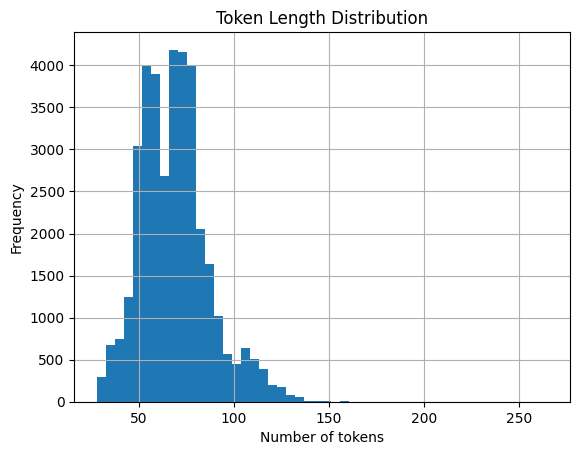

In [ ]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 1 train sample(s) with more than 256 tokens


array([ 28,  28,  28, ..., 182, 229, 265], shape=(36696,))

In [ ]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",   # <- use this if your transformers is recent
    save_strategy="steps",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
    bf16=False,
    fp16=True,
)

In [ ]:
from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

/tmp/ipython-input-3413608890.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.save_model(f"ver_{VER}")
tokenizer.save_pretrained(f"ver_{VER}")

('ver_1/tokenizer_config.json',
 'ver_1/special_tokens_map.json',
 'ver_1/spm.model',
 'ver_1/added_tokens.json',
 'ver_1/tokenizer.json')

In [ ]:
test = pd.read_csv('/content/test.csv')
print( test.shape )
test.sample(2)

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...


In [ ]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [ ]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission10.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Misconception:Firstterm True_Correct:NA T...
1,36697,True_Misconception:Firstterm True_Correct:NA T...
2,36698,True_Misconception:Firstterm True_Correct:NA T...


In [ ]:
# =====================
# Stage 1: Retrieval
# =====================
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util

# Build misconception knowledge store
misconceptions = list(le.classes_)  # ["Category:Misconception", ...]
miscon_store = pd.DataFrame({"misconception": misconceptions})

# Sentence embeddings model for retrieval
retriever = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Encode misconceptions
miscon_embs = retriever.encode(miscon_store.misconception.tolist(), convert_to_tensor=True)

# BM25 tokenization
tokenized_miscons = [m.split() for m in miscon_store.misconception]
bm25 = BM25Okapi(tokenized_miscons)

def retrieve_candidates(text, top_k=20):
    """Retrieve top-k misconceptions using Bi-encoder + BM25 hybrid."""
    # Bi-encoder
    query_emb = retriever.encode(text, convert_to_tensor=True)
    bi_scores = util.cos_sim(query_emb, miscon_embs)[0].cpu().numpy()

    # BM25
    bm25_scores = bm25.get_scores(text.split())

    # Hybrid score = weighted sum
    scores = 0.7 * bi_scores + 0.3 * bm25_scores
    topk_idx = scores.argsort()[-top_k:][::-1]
    return miscon_store.iloc[topk_idx].misconception.values

# =====================
# Stage 2: Cross-Encoder
# =====================
from transformers import AutoModelForSequenceClassification

cross_encoder = AutoModelForSequenceClassification.from_pretrained(
   model_name,
    num_labels=n_classes
).to(device)  # your flan-t5-large fine-tuned classifier

def rerank_with_cross_encoder(student_text, candidates):
    """Re-rank candidates using cross-encoder."""
    pairs = [
        f"Question: {student_text}\nCandidate Misconception: {cand}"
        for cand in candidates
    ]

    inputs = tokenizer(
    pairs,
    padding=True,
    truncation=True,
    return_tensors="pt"
).to(device)
    with torch.no_grad():
        logits = cross_encoder(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[:, 1]  # probability of match

    ranked = sorted(zip(candidates, probs.cpu().numpy()), key=lambda x: -x[1])
    return ranked[:3]  # return top-3

# =====================
# Apply on Test Set
# =====================
predictions = []
for _, row in test.iterrows():
    student_text = row["text"]

    # Stage 1: retrieval
    candidates = retrieve_candidates(student_text, top_k=20)

    # Stage 2: re-ranking
    top3 = rerank_with_cross_encoder(student_text, candidates)
    top3_labels = [c for c, _ in top3]

    predictions.append(" ".join(top3_labels))

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": predictions
})
sub.to_csv("submission_pipeline.csv", index=False)
print(sub.head())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


   row_id                             Category:Misconception
0   36696  False_Misconception:Wrong_fraction False_Misco...
1   36697  False_Misconception:Wrong_Fraction False_Misco...
2   36698  True_Misconception:Whole_numbers_larger False_...


In [ ]:
import numpy as np
import torch

def mapk(y_true, y_pred, k=3):
    """
    Compute Mean Average Precision at k (MAP@k).
    y_true: [n_samples] true class indices
    y_pred: [n_samples, n_classes] predicted probabilities
    """
    topk = np.argsort(-y_pred, axis=1)[:, :k]
    score = 0.0
    for i, true in enumerate(y_true):
        if true in topk[i]:
            rank = np.where(topk[i] == true)[0][0] + 1
            score += 1.0 / rank
    return score / len(y_true)



In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=1)

    # Accuracy (Top-1)
    acc = (preds == labels).mean()

    # MAP@3
    map3_score = mapk(labels, probs, k=3)

    return {"accuracy": acc, "map@3": map3_score}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # <-- new
)


/tmp/ipython-input-1460661605.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Map@3
200,1.849000,1.677132,0.573978,0.673433
400,1.410200,1.331388,0.622071,0.723320
600,1.270300,1.147693,0.663215,0.765622
800,1.175000,1.038015,0.683924,0.794709
1000,1.018100,0.928396,0.705450,0.809491
1200,0.944200,0.886672,0.713488,0.830064
1400,0.937500,0.894260,0.715259,0.831744
1600,0.850100,0.759744,0.743460,0.849818
1800,0.734800,0.846131,0.722071,0.836580
2000,0.671300,0.754715,0.761989,0.861444


TrainOutput(global_step=7340, training_loss=0.7396652686823292, metrics={'train_runtime': 5915.8753, 'train_samples_per_second': 9.924, 'train_steps_per_second': 1.241, 'total_flos': 7728395689660416.0, 'train_loss': 0.7396652686823292, 'epoch': 2.0})

In [ ]:
trainer.evaluate()


{'eval_loss': 0.5071238279342651,
 'eval_accuracy': 0.8438692098092643,
 'eval_map@3': 0.9117166212534054,
 'eval_runtime': 50.9567,
 'eval_samples_per_second': 144.044,
 'eval_steps_per_second': 9.008,
 'epoch': 2.0}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/my_nlp_model"  # choose any folder name

trainer.save_model(output_dir)            # ✅ saves model weights + config
# tokenizer.save_pretrained(output_dir)     # ✅ saves tokenizer too


# **Prediction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd

# Path to the saved model in Drive
model_path = "/content/drive/MyDrive/my_nlp_model"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [ ]:
te_df = pd.read_csv("/content/test.csv")

# Change this to the actual text column name
texts = te_df["StudentExplanation"].tolist()


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16
all_preds = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]

    # Tokenize
    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

    all_preds.extend(preds.cpu().numpy())


In [ ]:
id2label = model.config.id2label  # <- correct mapping used during training
te_df["predicted_label"] = [id2label[int(p)] for p in all_preds]

In [ ]:
# Combine Category and Misconception into a single label
train_df['combined_label'] = train_df.apply(
    lambda x: f"{x['Category']}:{x['Misconception'] if pd.notna(x['Misconception']) else 'NA'}", axis=1
)

# Get unique combined labels and create mapping
unique_labels = sorted(train_df['combined_label'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Total labels:", len(unique_labels))
print(list(id2label.items())[:66])  # preview first 10


Total labels: 65
[(0, 'False_Correct:NA'), (1, 'False_Misconception:Adding_across'), (2, 'False_Misconception:Adding_terms'), (3, 'False_Misconception:Additive'), (4, 'False_Misconception:Base_rate'), (5, 'False_Misconception:Certainty'), (6, 'False_Misconception:Definition'), (7, 'False_Misconception:Denominator-only_change'), (8, 'False_Misconception:Division'), (9, 'False_Misconception:Duplication'), (10, 'False_Misconception:Firstterm'), (11, 'False_Misconception:FlipChange'), (12, 'False_Misconception:Ignores_zeroes'), (13, 'False_Misconception:Incomplete'), (14, 'False_Misconception:Incorrect_equivalent_fraction_addition'), (15, 'False_Misconception:Interior'), (16, 'False_Misconception:Inverse_operation'), (17, 'False_Misconception:Inversion'), (18, 'False_Misconception:Irrelevant'), (19, 'False_Misconception:Longer_is_bigger'), (20, 'False_Misconception:Mult'), (21, 'False_Misconception:Multiplying_by_4'), (22, 'False_Misconception:Not_variable'), (23, 'False_Misconception:Posi

In [ ]:
print(te_df[["StudentExplanation", "predicted_label"]].head())

                                  StudentExplanation predicted_label
0  I think that 1/3 is the answer, as it's the si...        LABEL_37
1  i think this answer is because 3 triangles are...        LABEL_64
2     because the 2 makes it higher than the others.        LABEL_64


In [ ]:
te_df["predicted_label"] = all_preds
print(te_df.head())


   row_id  QuestionId                                       QuestionText  \
0   36696       31772  What fraction of the shape is not shaded? Give...   
1   36697       31772  What fraction of the shape is not shaded? Give...   
2   36698       32835                      Which number is the greatest?   

           MC_Answer                                 StudentExplanation  \
0  \( \frac{1}{3} \)  I think that 1/3 is the answer, as it's the si...   
1  \( \frac{3}{6} \)  i think this answer is because 3 triangles are...   
2          \( 6.2 \)     because the 2 makes it higher than the others.   

   predicted_label  
0               37  
1               64  
2               64  


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")
unique_labels = sorted(train_df["Category"].unique())
id2label = {i: label for i, label in enumerate(unique_labels)}
